In [1253]:
#we have to import just what we need
#This is using Random forest variables regression method.

from sklearn.ensemble import RandomForestRegressor

#this for error meetric for R^2
from sklearn.metrics import roc_auc_score

import os
import pandas as pd
%pylab inline

X = pd.read_csv('train.csv')
Y = X.pop('Survived')

Populating the interactive namespace from numpy and matplotlib


In [1254]:
X.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [1255]:
#inputing age which are not filled
X['Age'].fillna(X.Age.mean(), inplace=True)

In [1256]:
X.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.836071,13.002015,1.102743,0.806057,49.693429
min,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,3.000000,29.699118,0.000000,0.000000,14.454200
75%,668.500000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [1257]:
#Getting just the numerical variables by selecting only variables that are not object datatypes.

numeric_variables = list(X.dtypes[X.dtypes != 'object'].index)
X[numeric_variables].head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
0,1,3,22.0,1,0,7.2500
1,2,1,38.0,1,0,71.2833
2,3,3,26.0,0,0,7.9250
3,4,1,35.0,1,0,53.1000
4,5,3,35.0,0,0,8.0500


In [1258]:
#first model 

model = RandomForestRegressor(n_estimators=100, oob_score=True, random_state=42)

#we are using only numeric avriables because we have to remove categorical variables.
model.fit(X[numeric_variables], Y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

In [1259]:
#For regression let us use only avaiable models in sklearn R^2 and c-stats based on the predictions.
model.oob_score_

0.1361695005913669

In [1260]:
y_oob = model.oob_prediction_
roc_auc_score(Y, y_oob)

0.73995515503999831

In [1261]:
#Now let write a simple function to show descriptive stats on the categorical variables.

def describe_categorical(X):
    
    from IPython.display import display, HTML
    display(HTML(X[X.columns[X.dtypes == 'object']].describe().to_html()))
    

In [1262]:
describe_categorical(X)

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Taylor, Mr. Elmer Zebley",male,347082,B96 B98,S
freq,1,577,7,4,644


In [1263]:
#lets drop down the variables which are not necessary
X.drop(['Name', 'Ticket', 'PassengerId'], axis=1, inplace=True)

In [1264]:
#clean the cabin variable to only be first letter or none
def clean_cabin(X):
    try:
        return X[0]
    except TypeError:
        return "None"
    
X['Cabin'] = X.Cabin.apply(clean_cabin)
    

In [1265]:
#X.Cabin

In [1266]:
categorical_variables = ['Sex', 'Cabin', 'Embarked']

for variable in categorical_variables:
    
    #filling Missing data with word Missing
    X[variable].fillna('Missing', inplace=True)
    #Create array of dummies
    dummies = pd.get_dummies(X[variable], prefix=variable)
    #update X to include dummies and drop main variable
    X = pd.concat([X, dummies], axis=1)
    X.drop([variable], axis=1, inplace=True)

In [1267]:
# look at all the colomns in dataset

def printall(X, max_rows=10):
    from IPython.display import display, HTML
    display(HTML(X.to_html(max_rows=max_rows)))
    
printall(X)

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_None,Cabin_T,Embarked_C,Embarked_Missing,Embarked_Q,Embarked_S
0,3,22.000000,1,0,7.2500,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
1,1,38.000000,1,0,71.2833,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0
2,3,26.000000,0,0,7.9250,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3,1,35.000000,1,0,53.1000,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1
4,3,35.000000,0,0,8.0500,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,27.000000,0,0,13.0000,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
887,1,19.000000,0,0,30.0000,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1
888,3,29.699118,1,2,23.4500,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
889,1,26.000000,0,0,30.0000,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0


In [1268]:
#Now we have a dataset so let us build a model
model = RandomForestRegressor(100, oob_score=True, n_jobs=-1, random_state=42)
model.fit(X, Y)
roc_auc_score(Y, model.oob_prediction_)

0.86352112826084637

In [1269]:
model.feature_importances_

array([  9.11384671e-02,   2.38891052e-01,   4.43567267e-02,
         2.15831071e-02,   2.15047796e-01,   1.43423437e-01,
         1.58822440e-01,   2.95342368e-03,   3.79055011e-03,
         6.47116172e-03,   4.30998991e-03,   8.59480266e-03,
         1.02403226e-03,   8.12054428e-04,   2.67741854e-02,
         6.64265010e-05,   1.06189189e-02,   0.00000000e+00,
         6.00379221e-03,   1.53176370e-02])

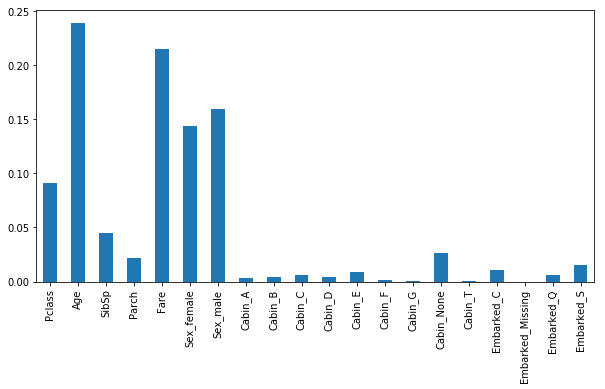

In [1270]:
# Simple version that shows all of variables
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
#feature_importances.sort()
feature_importances.plot(kind='bar', figsize=(10,5))

In [1314]:
#let us visualise more in detail

def graph_feature_importances(model, feature_names, autoscale=True, headroom=0.05, width=10, summarized_columns=None):
    
    if autoscale:
        x_scale = model.feature_importances_.max()+ headroom
    else:
        x_scale = 1
    feature_dict=dict(zip(feature_names, model.feature_importances_))
    
    if summarized_columns:
        for col_name in summarized_columns:
            #sum all the features that contain column names
            sum_value = sum(x for i, x in feature_dict.items() if col_name in i)
            
            #remove all the keys that are apart of column names
            keys_to_remove = [i for i in feature_dict.keys() if col_name in i]
            for i in keys_to_remove:
                feature_dict.pop(i)
            #read summarized feild
            feature_dict[col_name] = sum_value
            
        results = pd.Series(feature_dict.values(), index=feature_dict.keys())
        #results.sort(axis=1)
        results.plot(kind='bar', figsize=(width,len(results)/4), xlim=(0, x_scale))
        
#graph_feature_importances(model, X.columns, summarized_columns=categorical_variables)

TypeError: Empty 'DataFrame': no numeric data to plot

In [1321]:
%time
model = RandomForestRegressor(1000, oob_score=True, n_jobs=1, random_state=42)
model.fit(X,Y)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 5.96 µs


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

In [1322]:
%time
model = RandomForestRegressor(1000, oob_score=True, n_jobs=-1, random_state=42)
model.fit(X,Y)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.91 µs


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

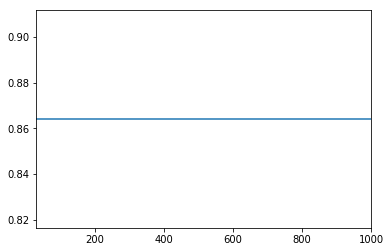

In [1281]:
#n-estimator
results= []
n_estimator_options = [30, 50, 100, 200, 500, 1000]

for trees in n_estimator_options:

    model = RandomForestRegressor(trees, oob_score=True, n_jobs=-1, random_state=42)
    model.fit(X,Y)
    

roc = roc_auc_score(Y, model.oob_prediction_)

results.append(roc)
print(roc)

pd.Series(results, n_estimator_options).plot();

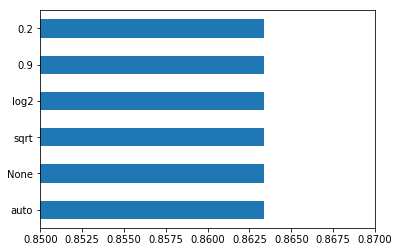

In [1296]:
#Max_features
results= []
max_features_options = ['auto', None, 'sqrt', 'log2', 0.9, 0.2]

for max_features in max_features_options:

    model = RandomForestRegressor(trees, oob_score=True, n_jobs=-1, random_state=42, max_features=max_features)
    model.fit(X,Y)
    

roc = roc_auc_score(Y, model.oob_prediction_)

results.append(roc)
print(roc)

pd.Series(results, max_features_options).plot(kind='barh', xlim=(.85,.87));

0.864458505097
0.864458505097


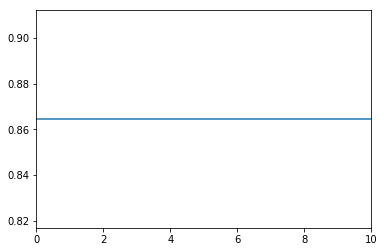

In [1311]:
#Min_features
results= []
min_samples_leaf_options = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

for min_samples in min_features_options:

    model = RandomForestRegressor(n_estimators=100, oob_score=True, 
                                  n_jobs=-1, random_state=42, 
                                  max_features='auto', min_samples_leaf=min_samples)
    model.fit(X,Y)
    

roc = roc_auc_score(Y, model.oob_prediction_)
print(roc)

results.append(roc)


pd.Series(results, min_samples_leaf_options).plot();

In [1307]:
model = RandomForestRegressor(n_estimators=1000, oob_score=True, 
                                  n_jobs=-1, random_state=42, 
                                  max_features='auto', min_samples_leaf=5)
model.fit(X,Y)
    

roc = roc_auc_score(Y, model.oob_prediction_)
print(roc)

0.874269005848
